# Generate primers for spike mutations in GISAID alignments

This script takes `spike_alignment_counts.csv` table, filters it for amino acids that are not already present in variant sequence and runs `create_primers_del.py` script to generate primers.

In [1]:
import pandas as pd
from plotnine import *
from Bio.SeqUtils import MeltingTemp as mt
import statistics

In [2]:
# import snakemake variables
gisaid_mutations = snakemake.input.gisaid_mutations
reference_lookup  = snakemake.input.reference_lookup
codon_table = snakemake.input.codon_table
spike_extended = snakemake.input.spike_extended
create_primers_srcipt = snakemake.input.create_primers_srcipt
gisaid_mutation_count_filter = snakemake.params.gisaid_mutation_count_filter

variant_gisaid_mutations_out = snakemake.output.variant_gisaid_mutations
variant_gisaid_primers_del = snakemake.output.variant_gisaid_primers_del
variant_gisaid_primers = snakemake.output.variant_gisaid_primers

In [3]:
gisaid_mutations = pd.read_csv(gisaid_mutations)
reference_lookup = pd.read_csv(reference_lookup)

In [4]:
#remove GISAID mutations that are in variant spike already
#merge lookup and gisaid tables
new_df = pd.merge(gisaid_mutations,
                  reference_lookup,
                  how='left',
                  left_on=['site','amino_acid'],
                  right_on = ['parent_pos','parent_seq'],
                  indicator=True)

#filter on amino acids not already present in variant
new_df_noWU = new_df.loc[(new_df['_merge'] == 'left_only') | (new_df['variant_sig'] == 'Yes')]
new_gisaid_mutations = new_df[new_df.index.isin(new_df_noWU.index)]
new_gisaid_mutations = new_gisaid_mutations[['site','amino_acid','alignment_counts']]

In [5]:
#now merge tables just on parent position, sort by position, and renumber by variant
new_gisaid_mutations = pd.merge(new_gisaid_mutations,
                  reference_lookup,
                  how='left',
                  left_on=['site'],
                  right_on = ['parent_pos'])

#drop positions with NaN in parent sequence removed CTD amino acids
new_gisaid_mutations = new_gisaid_mutations[new_gisaid_mutations['parent_pos'].notna()]
new_gisaid_mutations = new_gisaid_mutations.sort_values(by=['site'],ignore_index=True )

In [6]:
#drop mutations that occur only once
new_gisaid_mutations=new_gisaid_mutations.loc[new_gisaid_mutations['alignment_counts'] > gisaid_mutation_count_filter]

In [7]:
#create new table with mutations according to variant numbering
variant_gisaid_mutations = new_gisaid_mutations[['variant_pos', 'amino_acid', 'alignment_counts']].copy()
variant_gisaid_mutations = variant_gisaid_mutations.rename(
                            columns={"variant_pos": "site",
                                     "amino_acid": "mutant",
                                     "alignment_counts": "alignment_counts" }
)
variant_gisaid_mutations.to_csv(variant_gisaid_mutations_out, index=False) 

In [8]:
# run primer design script
!python {create_primers_srcipt} \
    {spike_extended} \
    {variant_gisaid_mutations_out} \
    {codon_table} \
    variantGISAID \
    {variant_gisaid_primers_del} \
    --minprimertm 60.5 \
    --maxprimertm 61.5

Read the following command line arguments
	sequencefile = ../reference_sequences/B16172_extended_ends_for_primers.txt
	mutations_csv = ../results/variant_gisaid_mutations.csv
	codon_frequency_csv = ../reference_sequences/homo_codon_freq_del.csv
	primerprefix = variantGISAID
	outfile = ../results/primers/variant_gisaid_primers_del.csv
	startprimerlength = 37
	maxprimertm = 61.5
	minprimertm = 60.5
	minlength = 25
	maxlength = 51
Read a sequence of length 3842 from ../reference_sequences/B16172_extended_ends_for_primers.txt:
cagccgagccacatcgctcaacgcgtgccaccATGTTTGTGTTCCTGGTGCTGCTGCCACTGGTGTCCAGCCAGTGTGTGAACCTGAGAACCAGGACCCAACTTCCTCCTGCCTACACCAACTCCTTCACCAGGGGAGTCTACTACCCTGACAAGGTGTTCAGGTCCTCTGTGCTGCACAGCACCCAGGACCTGTTCCTGCCATTCTTCAGCAATGTGACCTGGTTCCATGCCATCCATGTGTCTGGCACCAATGGCACCAAGAGGTTTGACAACCCTGTGCTGCCATTCAATGATGGAGTCTACTTTGCCAGCACAGAGAAGAGCAACATCATCAGGGGCTGGATTTTTGGCACCACCCTGGACAGCAAGACCCAGTCCCTGCTGATTGTGAACAATGCCACCAATGTGGTGATTAAGGTGTGTGAGTTCCAGTTCTGTAATGACCCATTCCTGGACGTCTACTACCACA

In [9]:
#import primer table
header_list = ["primer_name", "seq"]
variantGISAID_primers = pd.read_csv(variant_gisaid_primers_del, names=header_list)
variantGISAID_primers

,primer_name,seq
0,variantGISAID-for-mut1-,cgcgtgccacc---TTTGTGTTCCTG
1,variantGISAID-for-mut1I,cgcgtgccaccATCTTTGTGTTCCT
2,variantGISAID-for-mut1V,cgcgtgccaccGTGTTTGTGTTCCT
3,variantGISAID-for-mut1L,cgcgtgccaccCTGTTTGTGTTCCT
4,variantGISAID-for-mut1N,cgcgtgccaccAACTTTGTGTTCCT
...,...,...
11591,variantGISAID-rev-mut1250C,gcctcattaTCAGCAGCCACAGGAACA
11592,variantGISAID-rev-mut1250T,gcctcattaTCAGGTGCCACAGGAACA
11593,variantGISAID-rev-mut1250-,gcgcctcattaTCA---GCCACAGGAACAA
11594,variantGISAID-rev-mut1250F,cgcctcattaTCAGAAGCCACAGGAACAA


In [10]:
#strip all --- strings that indicate deletions
variantGISAID_primers['seq'] = variantGISAID_primers['seq'].replace('-', '', regex=True).astype(str)
variantGISAID_primers

,primer_name,seq
0,variantGISAID-for-mut1-,cgcgtgccaccTTTGTGTTCCTG
1,variantGISAID-for-mut1I,cgcgtgccaccATCTTTGTGTTCCT
2,variantGISAID-for-mut1V,cgcgtgccaccGTGTTTGTGTTCCT
3,variantGISAID-for-mut1L,cgcgtgccaccCTGTTTGTGTTCCT
4,variantGISAID-for-mut1N,cgcgtgccaccAACTTTGTGTTCCT
...,...,...
11591,variantGISAID-rev-mut1250C,gcctcattaTCAGCAGCCACAGGAACA
11592,variantGISAID-rev-mut1250T,gcctcattaTCAGGTGCCACAGGAACA
11593,variantGISAID-rev-mut1250-,gcgcctcattaTCAGCCACAGGAACAA
11594,variantGISAID-rev-mut1250F,cgcctcattaTCAGAAGCCACAGGAACAA


## Analyse primers

Analyse primer annealing temperatures.

In [11]:
variantGISAID_primers['Tm'] = variantGISAID_primers.apply(lambda x: '%0.2f' % mt.Tm_NN(x.seq, strict=False), axis=1)
variantGISAID_primers['Tm'] = variantGISAID_primers['Tm'].astype('float')
variantGISAID_primers['length'] = variantGISAID_primers.apply(lambda x: len(x.seq), axis=1)
variantGISAID_primers

,primer_name,seq,Tm,length
0,variantGISAID-for-mut1-,cgcgtgccaccTTTGTGTTCCTG,61.24,24
1,variantGISAID-for-mut1I,cgcgtgccaccATCTTTGTGTTCCT,62.12,26
2,variantGISAID-for-mut1V,cgcgtgccaccGTGTTTGTGTTCCT,64.39,26
3,variantGISAID-for-mut1L,cgcgtgccaccCTGTTTGTGTTCCT,63.95,26
4,variantGISAID-for-mut1N,cgcgtgccaccAACTTTGTGTTCCT,62.50,26
...,...,...,...,...
11591,variantGISAID-rev-mut1250C,gcctcattaTCAGCAGCCACAGGAACA,60.96,28
11592,variantGISAID-rev-mut1250T,gcctcattaTCAGGTGCCACAGGAACA,60.70,28
11593,variantGISAID-rev-mut1250-,gcgcctcattaTCAGCCACAGGAACAA,61.42,28
11594,variantGISAID-rev-mut1250F,cgcctcattaTCAGAAGCCACAGGAACAA,60.90,30


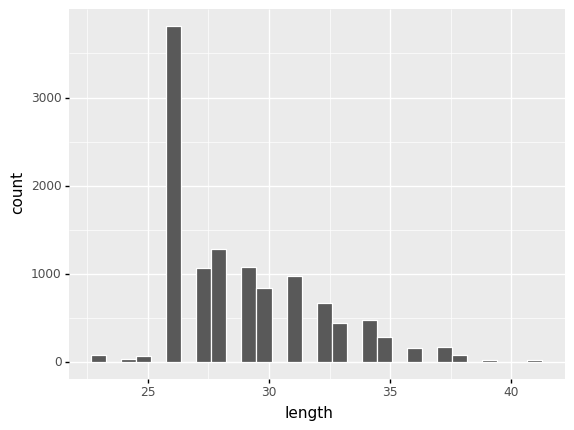

<bound method ggplot.draw of <ggplot: (8785669658329)>>

In [12]:
p = (ggplot(variantGISAID_primers) + 
     aes('length') + 
     geom_histogram(color='white',bins=30)
    )

p.draw

/fh/fast/bloom_j/software/miniconda3/envs/BloomLab/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


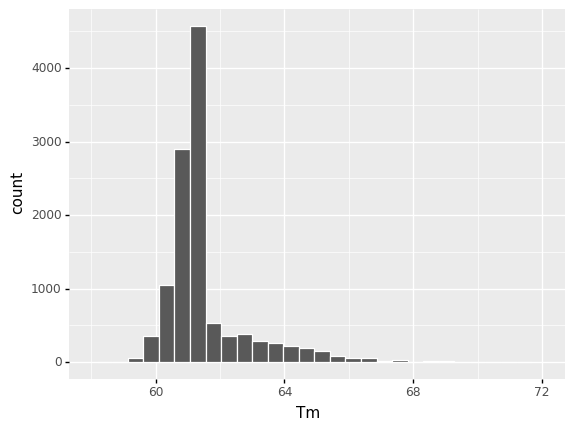

<bound method ggplot.draw of <ggplot: (8786314031942)>>

In [13]:
p = (ggplot(variantGISAID_primers) + 
     aes('Tm') + 
     geom_histogram(color='white', bins=30)+
     xlim(58,72)
    )

p.draw

In [14]:
statistics.pvariance(variantGISAID_primers['Tm'])

1.7381507798540277

In [15]:
# finish by exporting primers
variantGISAID_primers.to_csv(variant_gisaid_primers, index=False) 